In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
data=pd.read_csv('diabetes.csv')

In [3]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
data.isnull().values.any()

False

In [5]:
(data==0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [6]:
def replace_zero(df, field, target):
    mean_by_target=df.loc[df[field]!=0, [field, target]].groupby(target).mean()
    data.loc[(df[field]==0)&(df[target]==0), field]=mean_by_target.iloc[0][0]
    data.loc[(df[field]==0)&(df[target]==1), field]=mean_by_target.iloc[1][0]
    
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:   
    replace_zero(data, col, 'Outcome') 

In [7]:
(data==0).sum()

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [8]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,206.846154,33.6,0.627,50,1
1,1,85.0,66.0,29.0,130.287879,26.6,0.351,31,0
2,8,183.0,64.0,33.0,206.846154,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.000000,32.9,0.171,63,0
764,2,122.0,70.0,27.0,130.287879,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.000000,26.2,0.245,30,0
766,1,126.0,60.0,33.0,206.846154,30.1,0.349,47,1


In [9]:
X=data.iloc[:,0:8].values
y=data.iloc[:,8].values

In [10]:
X

array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

In [11]:
y

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,

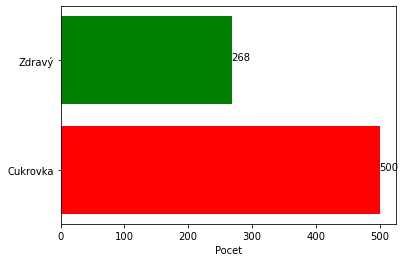

In [12]:
values=data['Outcome'].value_counts()
labels=["Cukrovka","Zdravý"]

plt.barh(labels, values, color=['red', 'green'])
plt.xlabel('Pocet')
for index, value in enumerate(values):
    plt.text(value, index,
             str(value))
plt.show()

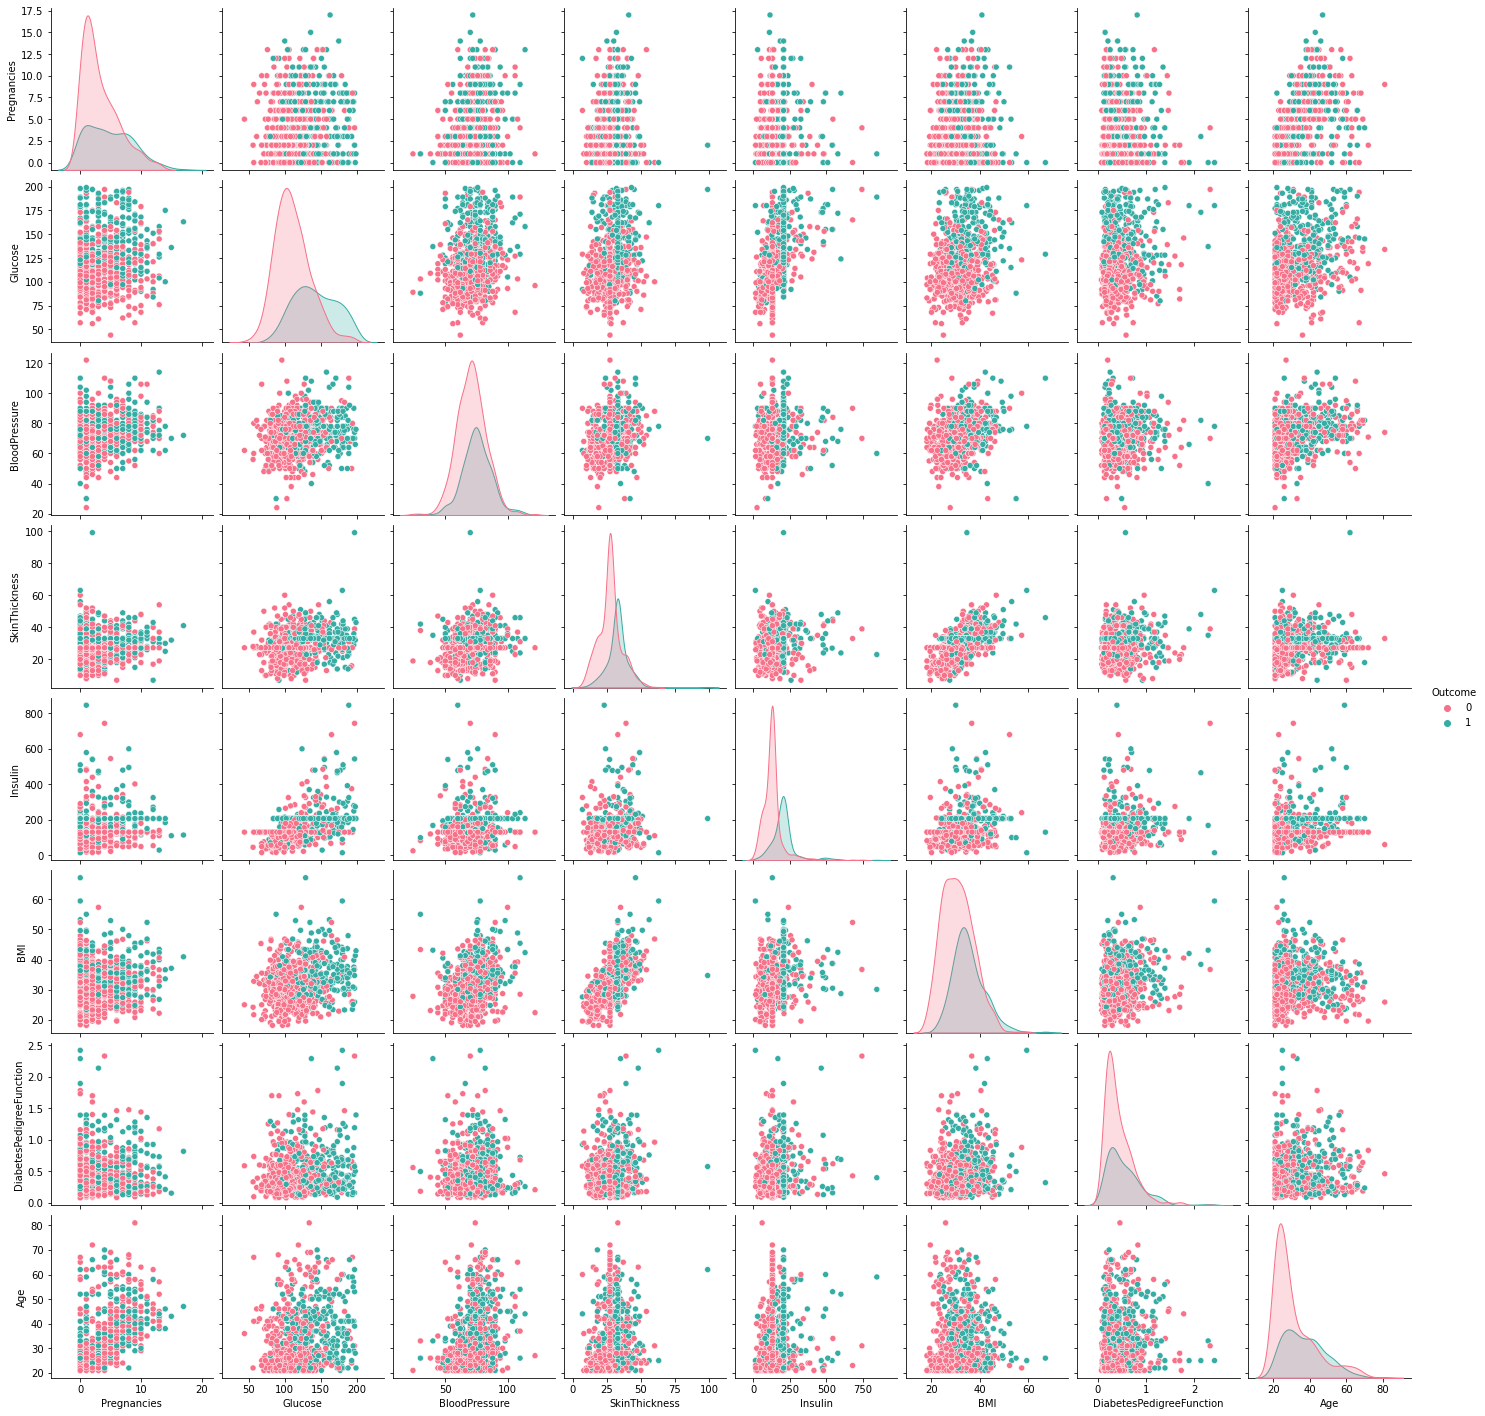

In [13]:
g = sns.pairplot(data, hue="Outcome", palette="husl")

In [14]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=10)

In [15]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [16]:
X_train

array([[-0.53788077, -1.06444498,  1.42268255, ...,  0.15809197,
        -0.51280558,  0.74882677],
       [ 0.06137644,  0.76134027,  1.01578288, ..., -0.52287657,
        -0.8218938 , -0.52209603],
       [ 1.85914807, -0.35975593, -0.20491613, ..., -0.73012786,
        -0.96593491,  0.57937039],
       ...,
       [-0.23825217, -0.19959933,  0.12060361, ..., -0.90777183,
        -1.06796403, -0.77628059],
       [-0.83750938, -1.0964763 , -3.46011348, ...,  3.34087969,
         0.09936914, -0.60682422],
       [ 0.36100504, -0.84022574,  0.12060361, ...,  0.17289563,
         1.60279824,  0.83355495]])

In [17]:
X_test

array([[ 0.06137644,  1.01759084, -0.04215626, ..., -0.16758864,
        -0.37476618,  0.32518583],
       [-0.53788077, -0.32772461,  1.09716281, ...,  0.8834715 ,
        -0.65084498, -0.43736785],
       [-0.83750938,  0.40899575, -1.50699507, ..., -0.84855717,
         0.67253273,  2.44339049],
       ...,
       [-0.23825217,  0.88946555,  0.28336347, ..., -1.69236601,
        -0.76787838,  0.32518583],
       [-0.23825217,  0.24883915, -0.69319573, ..., -1.38148907,
        -0.44678674, -0.94573696],
       [-1.13713798, -0.45584989, -0.367676  , ..., -0.75973519,
         0.97261838, -0.0984551 ]])

In [18]:
random_forest_model=RandomForestClassifier(random_state=10)
random_forest_model.fit(X_train, y_train.ravel())

RandomForestClassifier(random_state=10)

In [19]:
predict_train_data=random_forest_model.predict(X_test)
print("Accuracy = {0:.3f}".format(metrics.accuracy_score(y_test, predict_train_data)))

Accuracy = 0.892
